# lighteval is your AI evaluation library

This notebook explores how you can use lighteval to evaluate and compare LLMs.

`lighteval` is a tool for getting eval score on major benchmarks. It's just been refactored to support being used like a library in Python, which makes it great for comparing models across benchmarks.

## Install dependencies

In [1]:
!pip install -qqq -U "torch<2.5" "torchvision<2.5" "torchaudio<2.5" --index-url https://download.pytorch.org/whl/cu121
!pip list | grep torch

torch                              2.4.1+cu121
torchaudio                         2.4.1+cu121
torchsummary                       1.5.1
torchvision                        0.19.1+cu121


In [2]:
!pip install -qqq git+https://github.com/huggingface/lighteval.git tiktoken

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## Setup `lighteval` evaluation

We need to setup the evaluation environment and pipeline. Much of this we will disable because we're keeping things in the notebook, but we could also use `push_to_hub` or `push_to_tensorboard`.

### `push_to_hub`

This is useful if we're evaluating a model and want to persist its evaluation with weights and configuration on the Hugging Face hub.

### `push_to_tensorboard`

This would be useful if we were building an evaluation tool or script, where we wanted to view results within tensorboard.

In [3]:
import lighteval
import os
from datetime import timedelta
from transformers import AutoModelForCausalLM

from lighteval.logging.evaluation_tracker import EvaluationTracker
from lighteval.pipeline import EnvConfig, ParallelismManager, Pipeline, PipelineParameters

TOKEN = os.getenv("HF_TOKEN")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [4]:
env_config = EnvConfig(token=TOKEN, cache_dir="~/tmp")

evaluation_tracker = EvaluationTracker(
    output_dir="~/tmp",
    save_details=False,
    push_to_hub=False,
    push_to_tensorboard=False,
    public=False,
    hub_results_org=False,
)

pipeline_params = PipelineParameters(
    launcher_type=ParallelismManager.ACCELERATE,
    env_config=env_config,
    job_id=1,
    override_batch_size=1,
    num_fewshot_seeds=0,
    max_samples=10,
    use_chat_template=False,
)

# Compares models with `lighteval`

We are going to compare two small LLMs on a MMLU domain. We will use `Qwen/Qwen2.5-0.5B` and `HuggingFaceTB/SmolLM2-135M` and we will evaluate them on a physics domain.

We can create a domain evaluation from a subset of HELM evaluations, by defining the evaluation tasks. In lighteval, tasks are described as strings.

`{suite}|{task}:{subtask}|{num_few_shot}|{0 or 1 to reduce num_few_shot if prompt is too long}`

Therefore, we will pass our list of medicine related tasks like this:

```
"helm|mmlu:college_physics|10|0,helm|mmlu:conceptual_physics|10|0,helm|mmlu:high_school_physics|10|0"
```

Which can be translated to :

| Suite | Task | Num Fewshot Example | Limit Fewshots |
|---|---|---|---|
| helm | mmlu:college_physics | 10 | False |
| helm | mmlu:conceptual_physics | 10 | False |
| helm | mmlu:high_school_physics | 10 | False |

For a full list of lighteval supported tasks. Checkout this page in [the documentation](https://github.com/huggingface/lighteval/wiki/Available-Tasks).

In [15]:
domain_tasks = """helm|mmlu:college_physics|10|0,helm|mmlu:conceptual_physics|10|0,helm|mmlu:high_school_physics|10|0"""

# Evaluate Qwen2.5 0.5B

In [17]:
qwen_model = AutoModelForCausalLM.from_pretrained("Qwen/Qwen2.5-0.5B")

pipeline = Pipeline(
    tasks=domain_tasks,
    pipeline_parameters=pipeline_params,
    evaluation_tracker=evaluation_tracker,
    model=qwen_model
)

pipeline.evaluate()

qwen_results = pipeline.get_results()

config.json:   0%|          | 0.00/681 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/7.23k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/7.23k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

Using the latest cached version of the dataset since lighteval/mmlu couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'college_physics' at /root/.cache/huggingface/datasets/lighteval___mmlu/college_physics/1.0.0/e24764f1fb58c26b5f622157644f2e5fe77e5b01 (last modified on Tue Dec 24 09:56:18 2024).
Using the latest cached version of the dataset since lighteval/mmlu couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'conceptual_physics' at /root/.cache/huggingface/datasets/lighteval___mmlu/conceptual_physics/1.0.0/e24764f1fb58c26b5f622157644f2e5fe77e5b01 (last modified on Tue Dec 24 09:56:23 2024).
Using the latest cached version of the dataset since lighteval/mmlu couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'high_school_physics' at /root/.cache/huggingface/datasets/lighteval___mmlu/high_school_physics/1.0.0/e24764f1fb58c26b5f622157644f2e5fe77e5b01 (last modified on Tue D

In [18]:
pipeline.show_results()

|              Task              |Version|Metric|Value |   |Stderr|
|--------------------------------|------:|------|-----:|---|-----:|
|all                             |       |em    |0.1717|±  |0.0662|
|                                |       |qem   |0.1717|±  |0.0662|
|                                |       |pem   |0.1717|±  |0.0662|
|                                |       |pqem  |0.3997|±  |0.0872|
|helm:mmlu:_average:10           |       |em    |0.1758|±  |0.0639|
|                                |       |qem   |0.1758|±  |0.0639|
|                                |       |pem   |0.1758|±  |0.0639|
|                                |       |pqem  |0.4055|±  |0.0832|
|helm:mmlu:college_physics:10    |      0|em    |0.2250|±  |0.0669|
|                                |       |qem   |0.2250|±  |0.0669|
|                                |       |pem   |0.2250|±  |0.0669|
|                                |       |pqem  |0.3750|±  |0.0775|
|helm:mmlu:conceptual_physics:10 |      0|em    

# Evaluate SmolLM 135M 

In [19]:
smol_model = AutoModelForCausalLM.from_pretrained("HuggingFaceTB/SmolLM2-135M")

pipeline = Pipeline(
    tasks=domain_tasks,
    pipeline_parameters=pipeline_params,
    evaluation_tracker=evaluation_tracker,
    model=smol_model
)

pipeline.evaluate()

Using the latest cached version of the dataset since lighteval/mmlu couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'college_physics' at /root/.cache/huggingface/datasets/lighteval___mmlu/college_physics/1.0.0/e24764f1fb58c26b5f622157644f2e5fe77e5b01 (last modified on Tue Dec 24 09:56:18 2024).
Using the latest cached version of the dataset since lighteval/mmlu couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'conceptual_physics' at /root/.cache/huggingface/datasets/lighteval___mmlu/conceptual_physics/1.0.0/e24764f1fb58c26b5f622157644f2e5fe77e5b01 (last modified on Tue Dec 24 09:56:23 2024).
Using the latest cached version of the dataset since lighteval/mmlu couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'high_school_physics' at /root/.cache/huggingface/datasets/lighteval___mmlu/high_school_physics/1.0.0/e24764f1fb58c26b5f622157644f2e5fe77e5b01 (last modified on Tue D

In [20]:
smol_results = pipeline.get_results()

In [21]:
pipeline.show_results()

|              Task              |Version|Metric|Value |   |Stderr|
|--------------------------------|------:|------|-----:|---|-----:|
|all                             |       |em    |0.1575|±  |0.0562|
|                                |       |qem   |0.1575|±  |0.0562|
|                                |       |pem   |0.1575|±  |0.0562|
|                                |       |pqem  |0.3610|±  |0.0744|
|helm:mmlu:_average:10           |       |em    |0.1539|±  |0.0537|
|                                |       |qem   |0.1539|±  |0.0537|
|                                |       |pem   |0.1539|±  |0.0537|
|                                |       |pqem  |0.3514|±  |0.0712|
|helm:mmlu:college_physics:10    |      0|em    |0.1800|±  |0.0549|
|                                |       |qem   |0.1800|±  |0.0549|
|                                |       |pem   |0.1800|±  |0.0549|
|                                |       |pqem  |0.3000|±  |0.0655|
|helm:mmlu:conceptual_physics:10 |      0|em    

`exact_match`: Fraction of instances where the prediction matches the gold with the exception of the border whitespaces (= after a strip has been applied to both).

`quasi_exact_match`: Fraction of instances where the normalized prediction matches the normalized gold (normalization done on whitespace, articles, capitalization, ...). Other variations exist, with other normalizers, such as quasi_exact_match_triviaqa, which only normalizes the predictions after applying a strip to all sentences.

`perfect_exact_match`: Fraction of instances where the prediction matches the gold exactly.

`prefix_quasi_exact_match`: Fraction of instances where the normalized beginning of the prediction matches the normalized gold (normalization done on whitespace, articles, capitalization, ...)

# Visualize Results

Now that we have results from the two models we can visualize them side-by-side. We'll keep visualisation simple here, but with this data structure you could represent scores in many ways.

<Axes: >

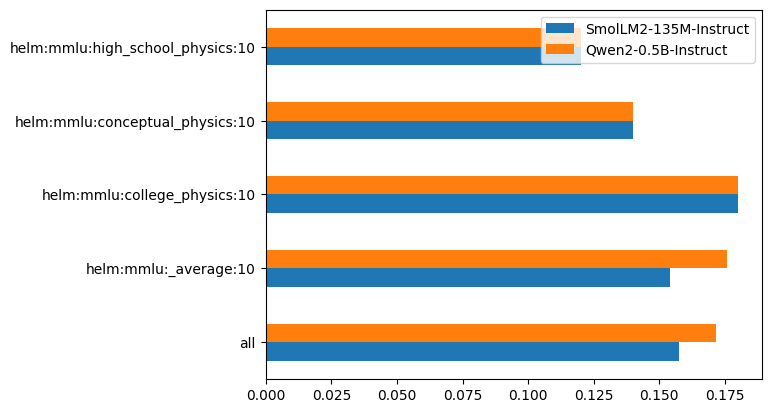

In [22]:
import pandas as pd

df = pd.DataFrame.from_records(smol_results["results"]).T["em"].rename("SmolLM2-135M")
_df = pd.DataFrame.from_records(qwen_results["results"]).T["em"].rename("Qwen2-0.5B")
df = pd.concat([df, _df], axis=1)
df.plot(kind="barh")